In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py
from copy import deepcopy
params = {'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large'}
plt.rcParams.update(params)

(40, 40, 40)
0
1
6.25


/var/folders/f5/zmpl7j_93n5bz1wd70hgb4140000gn/T/ipykernel_4101/1291511500.py:54: RuntimeWarning: invalid value encountered in divide
  composition[i]/=phi_tot


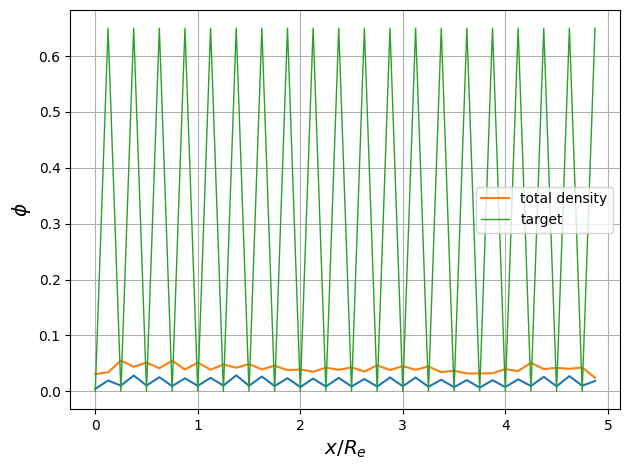

1.1729958398437499


In [4]:
offset=1 #to account for area51

plt.figure(dpi=100)
plt.grid()
y=0

with h5py.File('coord.h5', 'r') as f:
    ##number of beads per polymer
    N=int(f['parameter/reference_Nbeads'][()]) 
    #kappa
    kappa=30/N
    ##number of polymers
    n_polym=int(f['parameter/n_polymers'][()]) 
    n_poly_type=int(f['parameter/n_poly_type'][()]) 
    n_types=int(f['parameter/n_types'][()]) 
    ##box dimensions 
    lxyz=np.array(f['parameter/lxyz'])
    ##box discretization
    nxyz=np.array(f['parameter/nxyz'])
    #discretization
    dxyz=lxyz/nxyz
    #adjust lengths and discretizations
    lxyz=lxyz-2*offset*dxyz
    nxyz=nxyz-2*offset
    #umbrella field
    umb_field=np.array(f["umbrella_field"])
    #area51
    area51=np.array(f["area51"])
with h5py.File(f'coord_ana.h5', 'r') as f:
    #only load every other frame, the others are not optimized
    phi=np.array(f['density_field'])
t=len(phi)
#average phi over time
phi=phi.mean(axis=0)
#box volume
V=np.prod(lxyz)
Nbar=n_polym/V
#cell volume
V_cell=np.prod(dxyz)
#number of accessible cells 
n_cells=int(len(area51[area51==0]))
#field scaling type
scale=n_cells/(N*n_polym)
#reshape density and umbrella field
phi=phi*scale
phi=phi[:,area51==0].reshape(phi.shape[0],nxyz[0],nxyz[1],nxyz[2])
phi_tot=np.sum(phi,axis=0)
print(phi_tot.shape)
#phi_tot[phi_tot==0]=1
umb_field=umb_field[umb_field>-1].reshape(2,nxyz[0],nxyz[2])
composition=deepcopy(phi)
for i in range(2):
    print(i)
    composition[i]/=phi_tot
#get phi and composition at y value where umbrella field is defined averaged over z
phi_mean=phi[:,:,y,:].mean(axis=2)
composition_mean=composition[:,:,y,:].mean(axis=2)
#volume
V=V_cell*n_cells
#average bead density
rho0=N*Nbar
#beads per cell
rhoc=rho0*V_cell 
print(rhoc)
#natural density fluctuations
var_phi=1/(rho0*kappa*V_cell) 
l_plot=np.arange(0,lxyz[0],dxyz[0])
plt.xlabel("$x/R_e$")
plt.ylabel(r"$\phi$")
plt.plot(l_plot,phi_mean[0])
plt.plot(l_plot,phi_mean[0]+phi_mean[1],label="total density")
#plt.plot(l_plot,composition_mean[0])

plt.plot(l_plot,umb_field[0,:,0],lw=1,label="target")
L=0.0
for x in range(nxyz[0]):
    for z in range(nxyz[2]):
        for j in range(2):
            L+=(composition[j,x,0,z]-umb_field[j,x,z])**2
L=L/len(umb_field.flatten())
plt.legend()
plt.tight_layout()
    #plt.savefig(f"amplitude_{dphi}_Nbar{Nbar}.pdf")
plt.show()
n_cells_target=len(umb_field[umb_field>-1])
opt=np.loadtxt(f"opt.csv")/(n_cells_target*var_phi)
print(opt.mean())
